#### Kaggle tmdb-box-office-prediction competition

https://www.kaggle.com/c/tmdb-box-office-prediction

#### Import and View Data

In [206]:
import pandas as pd
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import seaborn as sns
import re
from tqdm import tqdm
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

In [208]:
df_modified = pd.read_csv('train.csv/train.csv')
df = df_modified
df.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [209]:
df.shape()

TypeError: 'tuple' object is not callable

#### Clean Data


Drop unique columns

In [179]:
df = df.drop(['imdb_id','id', 'title', 'tagline', 'poster_path', 'overview', 'original_title'], axis=1)

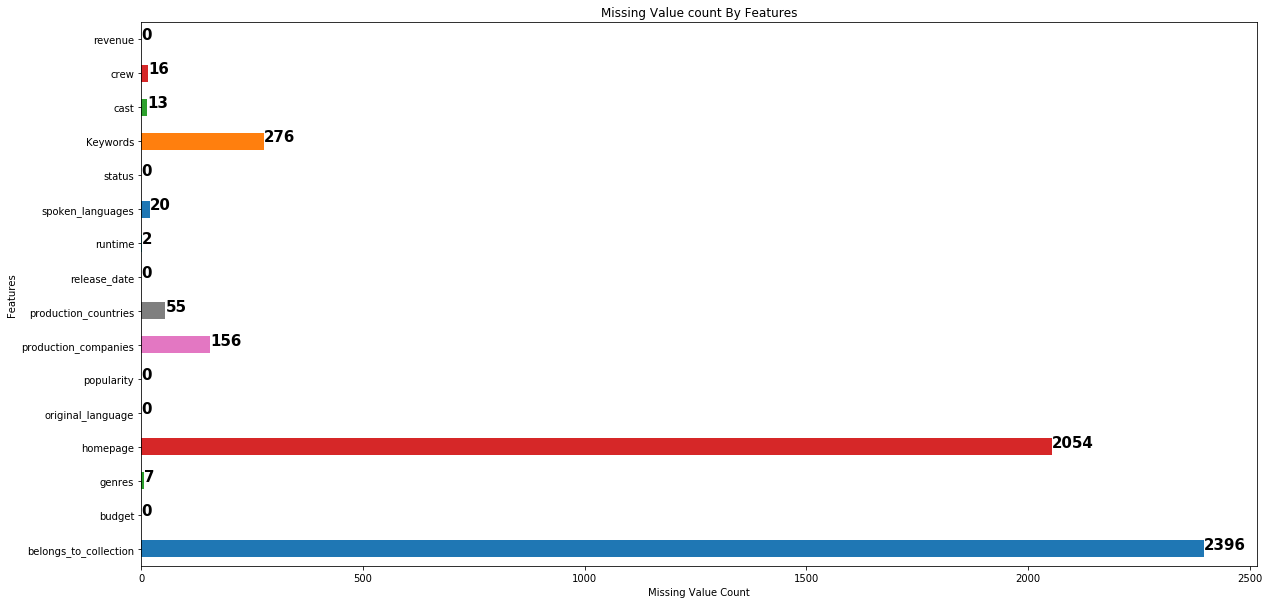

In [180]:
def NullCheckGraph(df):
    df.isna().sum().plot(kind="barh", figsize=(20,10))
    for i, v in enumerate(df.isna().sum()):
        plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
    plt.xlabel("Missing Value Count")
    plt.ylabel("Features")
    plt.title("Missing Value count By Features")
    
NullCheckGraph(df)

Drop column where 70% data is null

In [181]:
df = df.drop(['belongs_to_collection', 'homepage'],axis = 1)

Drop rows with Null values

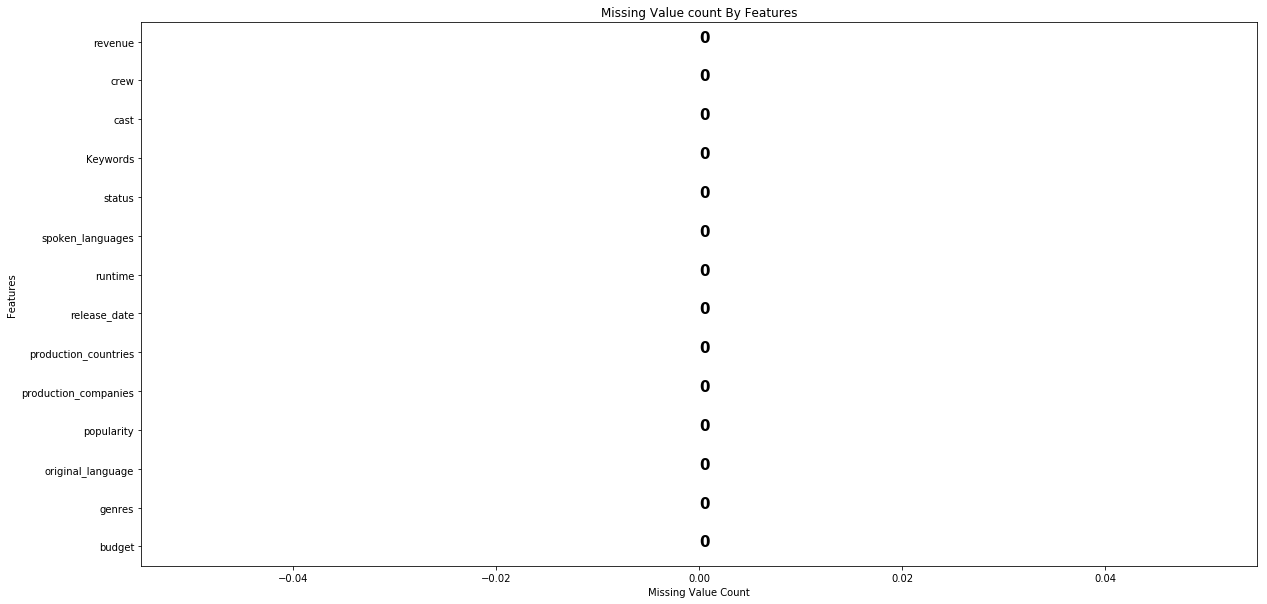

In [182]:
df.dropna(subset=["cast","production_companies","production_countries","crew","spoken_languages", "Keywords"],inplace=True)
df = df.reset_index(drop=True)
NullCheckGraph(df)

##### Cleaning List column

1. Genres

In [183]:
#Fetch only name from genres column

df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x,list) else [])
"""
genres_list = []

#Gen all unique genres to create columns
for genres_row in df['genres']:
    #print(genres_row)
    for j in range(len(genres_row)):
        #print(genres_list)
        genres_list.append(genres_row[j])

unique_genres = list(set(genres_list))

# Create separate column for all genres
for i in unique_genres:
    #print(i)
    df[i] = pd.Series(data = 0)

#Set respective genres to 1
for i in range(len(df['genres'])):
    if i in df['genres']:
        genres_row = df['genres'][i]
        for j in range(len(genres_row)):
            #print(genres_row, genres_row[j])
            col_name = genres_row[j]
            #print(col_name)       
            df.iloc[i,df.columns.get_loc(col_name)] = 1
        #print("key error")
        #print("'break'")"""

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres')), columns=mlb.classes_, index=df.index))

df.head(1)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,14000000,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",...,0,0,0,0,0,0,0,0,0,0


2. Converting to list: cast, crew, production_companies, production_countries, spoken_languages column

In [184]:
"""Safely evaluate an expression node or a Unicode or Latin-1 encoded string containing a Python expression. 
The string or node provided may only consist of the following Python literal structures: strings, numbers, 
tuples, lists, dicts, booleans, and None. This can be used for safely evaluating strings containing Python expressions 
from untrusted sources without the need to parse the values oneself.

Also read issue with CSV
https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list

https://stackoverflow.com/questions/29552950/when-to-use-ast-literal-eval"""

#df['cast'] = df['cast'].apply(literal_eval)
#df['crew'] = df['crew'].apply(literal_eval)
#df['production_companies'] = df['production_companies'].apply(literal_eval)
#df['production_countries'] = df['production_countries'].apply(literal_eval)
#df['spoken_languages'] = df['spoken_languages'].apply(literal_eval)
#df['keywords'] = df['keywords'].apply(literal_eval)

'Safely evaluate an expression node or a Unicode or Latin-1 encoded string containing a Python expression. \nThe string or node provided may only consist of the following Python literal structures: strings, numbers, \ntuples, lists, dicts, booleans, and None. This can be used for safely evaluating strings containing Python expressions \nfrom untrusted sources without the need to parse the values oneself.\n\nAlso read issue with CSV\nhttps://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list\n\nhttps://stackoverflow.com/questions/29552950/when-to-use-ast-literal-eval'

##### Extracting feature from cast column

In [185]:
def get_director(x):
    for i in x:
        if['job'] == 'Director':
            return i['name']
    return np.nan
    
df['director'] = df['crew'].apply(get_director)

#One hot encode 
dfDummies = pd.get_dummies(df['director'], prefix = 'director')
df = pd.concat([df,dfDummies], axis=1)

df['cast'] = df['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('cast')), columns=mlb.classes_, index=df.index))

#mlb = MultiLabelBinarizer()
#df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('director')), columns=mlb.classes_, index=df.index))

df.head(1)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,director
0,14000000,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",...,0,0,0,0,0,0,0,0,0,NaN


##### Cleaning spoken_languages

In [186]:
df['spoken_languages'] = df['spoken_languages'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('spoken_languages')), columns=mlb.classes_, index=df.index))

df.head(1)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,status,Keywords,crew,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,director
0,14000000,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",...,0,0,0,0,0,0,0,0,0,NaN


##### Cleaning production_companies

In [187]:
df['production_companies'] = df['production_companies'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_companies')), columns=mlb.classes_, index=df.index))

df.head(1)

,budget,original_language,popularity,production_countries,release_date,runtime,status,Keywords,crew,revenue,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,director
0,14000000,en,6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,...,0,0,0,0,0,0,0,0,0,NaN


##### Cleaning production_countries

In [188]:
df['production_countries'] = df['production_countries'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_countries')), columns=mlb.classes_, index=df.index))

df.head(1)

,budget,original_language,popularity,release_date,runtime,status,Keywords,crew,revenue,Action,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,director
0,14000000,en,6.575393,2/20/15,93.0,Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,...,0,0,0,0,0,0,0,0,0,NaN


##### One hot encode Original_Language 

In [189]:
dfDummies = pd.get_dummies(df['original_language'], prefix = 'original_language')

df = pd.concat([df,dfDummies], axis=1)

df.head(1)

,budget,original_language,popularity,release_date,runtime,status,Keywords,crew,revenue,Action,...,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tr,original_language_zh
0,14000000,en,6.575393,2/20/15,93.0,Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,...,0,0,0,0,0,0,0,0,0,0


##### One hot encode Status

In [190]:
dfDummies = pd.get_dummies(df['status'], prefix = 'status')

df = pd.concat([df,dfDummies], axis=1)

df.head(1)

,budget,original_language,popularity,release_date,runtime,status,Keywords,crew,revenue,Action,...,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tr,original_language_zh,status_Released,status_Rumored
0,14000000,en,6.575393,2/20/15,93.0,Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,...,0,0,0,0,0,0,0,0,1,0


##### Get year from Date and One hot encode it

In [191]:
#df['release_date'].head(5)

In [192]:
df['release_date'] = pd.to_datetime(df['release_date'])
#df['release_date'].head(5)

In [193]:
df['year'] = df['release_date'].dt.year

#dfDummies = pd.get_dummies(df['year'], prefix = 'release_year')

#df = pd.concat([df,dfDummies], axis=1)

df['year'].head(5)
#min(df['year'])
#max(df['year'])

0    2015
1    2004
2    2014
3    1996
4    2003
Name: year, dtype: int64

##### Drop column after One-Hot encoding 
##### TODO: work on Keywords, crew

In [194]:
df = df.drop(['original_language', 'status', 'Keywords', 'crew', 'release_date', 'director'], axis=1)

#### Check for NULL values

In [195]:
df.columns[df.isna().any()].tolist()

[]

In [ ]:
#NullCheckGraph(df)

#### Find co related features

In [ ]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

In [ ]:
#plot_corr(df)

In [ ]:
sns.heatmap(df.corr(), cmap='YlGnBu', annot = True, linewidths = 0.2)

#### Lets explore our data more via charts

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

df['status'].value_counts().head(5).plot.bar(ax=axarr[0][0], fontsize=12, color='mediumvioletred')
ax=axarr[0][0].set_xlabel("status", fontsize=18)
df['budget'].value_counts().head(5).plot.bar(ax=axarr[0][1], fontsize=12, color='mediumvioletred')
ax=axarr[0][1].set_title("budget", fontsize=18)
df['popularity'].value_counts().head(5).plot.bar(ax=axarr[1][0], fontsize=12, color='mediumvioletred')
ax=axarr[1][1].set_xlabel("popularity", fontsize=18)
df['runtime'].value_counts().head(5).plot.bar(ax=axarr[1][1], fontsize=12, color='mediumvioletred')
ax=axarr[1][1].set_xlabel("runtime", fontsize=18)


#### Feature Analysis

#### 1. Budget

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['budget'], y = df['revenue'], marker = 'x', color = 'black')

plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('Buged impact')
plt.legend()
plt.show()

#### 2. Popularity

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['popularity'], y = df['revenue'], marker = 'x', color = 'black')

plt.xlabel('popularity')
plt.ylabel('revenue')
plt.title('popularity impact')
plt.legend()
plt.show()

#### 3. Runtime

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['runtime'], y = df['revenue'], marker = 'x', color = 'black')

plt.xlabel('runtime')
plt.ylabel('revenue')
plt.title('popularity impact')
plt.legend()
plt.show()

##### 4. Language

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['original_language'], y = df['revenue'], marker = 'x', color = 'black')

plt.xlabel('original_language')
plt.ylabel('revenue')
plt.title('Language impact')
plt.legend()
plt.show()

In [ ]:
df.columns

In [ ]:
#X = df.loc[:,df.columns!='revenue']
#y = df['revenue']

df.status = pd.get_dummies(df.status)

df = df[['runtime', 'budget','popularity','status','genres', 'original_language', 'production_countries', '']]
df.isna().any()

#### Removing Null values from runtime

In [ ]:
# ffill: propagate last valid observation forward to next valid
# mean: takes mean of non-zero column and replaces zero with those. This should be modified
#df['runtime'] = df['runtime'].fillna(method='ffill')
mean_runtime = df['runtime'].mean(skipna=True)
mean_budget = df['budget'].mean(skipna=True)
df['runtime'] = df.runtime.replace(0, mean_runtime)
df['budget'] = df.budget.replace(0, mean_budget)
df.isna().any()

#### Check for 0 or Null values

In [ ]:
#'runtime', 'budget','popularity','status'

print("# rows in dataframe {0}".format(len(df)))
print("# rows null = %s, # of 0 = %s runtime" %(len(df.loc[df['runtime'].isnull()]), len(df.loc[df['runtime'] == 0])))
print("# rows null = %s, # of 0 = %s budget" %(len(df.loc[df['budget'].isnull()]), len(df.loc[df['budget'] == 0])))
print("# rows null = %s, # of 0 = %s popularity" %(len(df.loc[df['popularity'].isnull()]), len(df.loc[df['popularity']== 0])))
print("# rows null = %s, # of 0 = %s status" %(len(df.loc[df['status'].isnull()]), len(df.loc[df['status'] == 0])))

In [196]:
X = df
y = df.revenue

X.drop(['revenue'], axis=1)

,budget,popularity,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tr,original_language_zh,status_Released,status_Rumored,year
0,14000000,6.575393,93.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,2015
1,40000000,8.248895,113.0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,2004
2,3300000,64.299990,105.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,2014
3,0,6.902423,100.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1996
4,6000000,4.672036,91.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,2003
5,1000000,14.774066,119.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1976
6,0,10.543750,98.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1987
7,15000000,20.726578,122.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1999
8,53000000,13.314233,118.0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,2005
9,102000000,20.666063,145.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2002


In [197]:
y[:2]

0    12314651
1    95149435
Name: revenue, dtype: int64

#### Split training data into training and test data

In [198]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val,y_train, y_val = train_test_split(X,y,test_size = 0.30, random_state = 42)

In [199]:
print("{0:0.2f}% in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_val)/len(df.index)) * 100))

69.99% in training set
30.01% in test set


### Prepare the model

##### Declare method used during model generic

RMSLE method to calculate RMSLE

In [200]:
import numpy as np

def rmsle(y_v,y_p): 
    return np.sqrt(np.mean(np.square(np.log1p(y_v)-np.log1p(y_p)))) 

##### Plot graph 

In [201]:
from matplotlib import pyplot

def printResult(X, y, pred, xLabel, yLabel, title):
    pyplot.scatter(X,y)
    pyplot.plot(np.sort(X,axis=0), pred)
    pyplot.xlabel(xLabel)
    pyplot.ylabel(yLabel)
    pyplot.title(title)
    pyplot.legend()
    pyplot.show()

#### 1. Linear Model

RMSLE(used in Kaggle competition) score of Linear Model is 4.837316592730985e-11
Accuracy: 1.0000
MAE: 0.0000


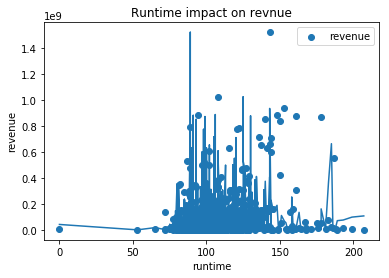

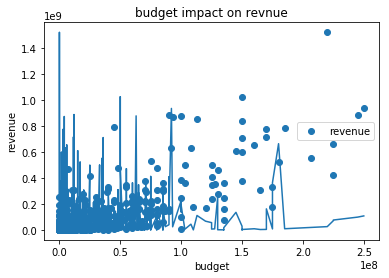

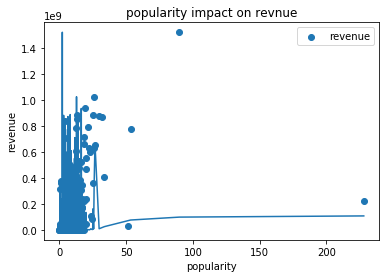

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_val)
print("RMSLE(used in Kaggle competition) score of Linear Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(lr_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

printResult(X_val.runtime, y_val, y_pred, 'runtime', 'revenue', 'Runtime impact on revnue')
printResult(X_val.budget, y_val, y_pred, 'budget', 'revenue', 'budget impact on revnue')
printResult(X_val.popularity, y_val, y_pred, 'popularity', 'revenue', 'popularity impact on revnue')

In [205]:
from sklearn.externals import joblib
joblib.dump(lr_model, 'lr_model.pkl', compress=9)

['lr_model.pkl']

#### Training Data Output

In [149]:
test = pd.read_csv('test.csv/test.csv')
test['runtime'] = test['runtime'].fillna(method='ffill')
test["status"] = pd.get_dummies(test.status)
test = test[['runtime', 'budget','popularity','status']]

y_LR_prediction = lr_model.predict(test)

sub_lr = pd.read_csv('sample_submission.csv')
sub_lr['revenue'] = y_LR_prediction
sub_lr.to_csv('LR_Submission.csv', index=False)

ValueError: shapes (4398,4) and (39920,) not aligned: 4 (dim 1) != 39920 (dim 0)

#### 2. RandomForestRegressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
print("RMSLE score of Random Forest Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(rf_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

printResult(X_val.runtime, y_val, y_pred, 'runtime', 'revenue', 'Runtime impact on revnue')
printResult(X_val.budget, y_val, y_pred, 'budget', 'revenue', 'budget impact on revnue')
printResult(X_val.popularity, y_val, y_pred, 'popularity', 'revenue', 'popularity impact on revnue')

##### Training Data Output

In [ ]:
y_RF_prediction = rf_model.predict(test)

sub_lr['revenue'] = y_RF_prediction
sub_lr.to_csv('RF_Submission.csv', index=False)

#### 3. KNeighborsRegressor

The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

kn_model = KNeighborsRegressor()
kn_model.fit(X_train, y_train)

y_pred = kn_model.predict(X_val)
print("RMSLE score of KNeighborsRegressor Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(kn_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

printResult(X_val.runtime, y_val, y_pred, 'runtime', 'revenue', 'Runtime impact on revnue')
printResult(X_val.budget, y_val, y_pred, 'budget', 'revenue', 'budget impact on revnue')
printResult(X_val.popularity, y_val, y_pred, 'popularity', 'revenue', 'popularity impact on revnue')

##### Training Data Output

In [ ]:
y_kn_prediction = kn_model.predict(test)

sub_lr['revenue'] = y_kn_prediction
sub_lr.to_csv('KN_Submission.csv', index=False)

#### 4. XGBRegressor

In [ ]:
from xgboost import XGBRegressor

xg_regressor_model = XGBRegressor()
xg_regressor_model.fit(X_train, y_train)

y_pred = xg_regressor_model.predict(X_val)
print("RMSLE score of XGBRegressor Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(xg_regressor_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

printResult(X_val.runtime, y_val, y_pred, 'runtime', 'revenue', 'Runtime impact on revnue')
printResult(X_val.budget, y_val, y_pred, 'budget', 'revenue', 'budget impact on revnue')
printResult(X_val.popularity, y_val, y_pred, 'popularity', 'revenue', 'popularity impact on revnue')

##### Training Data Output

In [ ]:
y_xg_regressor_prediction = xg_regressor_model.predict(test)

sub_lr['revenue'] = y_xg_regressor_prediction
sub_lr.to_csv('XGBoost_Regressor_Submission.csv', index=False)

#### 5. XGBClassifier

In [ ]:
"""from xgboost import XGBClassifier

xg_classifier_model = XGBClassifier()
xg_classifier_model.fit(X_train, y_train)

y_pred = xg_classifier_model.predict(X_val)
print("RMSLE score of XGBClassifier Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(xg_classifier_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))"""

In [ ]:
"""y_xg_classifier_prediction = xg_classifier_model.predict(test)

sub_lr['revenue'] = y_xg_classifier_prediction
sub_lr.to_csv('XGBoost_Regressor_Submission.csv', index=False)"""

#### "End Of Project" Check the directory, all the o/p files will be present there. We can upload the best one in the competition